# 模型訓練模式

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

from csidataset import *
import data_loader
from data_loader import *
sys.path.append("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool")
import denoise
from model import *

In [2]:
print(torch.cuda.is_available())

True


## 資料載入

In [3]:
base_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1221_phone/5G/20Mhz/csv/all"
base_path2 = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1222_phone/5G/20MHz/csv/all"
base_path3 = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1223_phone/5G/20MHz/csv/all"

In [4]:
reference_points = {}
reference_points2 = {}
reference_points3 = {}
spacing = 0.6  # 每隔 0.6m

for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(base_path, f"reference_point_{ref_id}.xlsx")
    reference_points[folder_path] = (ref_id, coord)

for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(base_path2, f"reference_point_{ref_id}.xlsx")
    reference_points2[folder_path] = (ref_id, coord)


for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(base_path3, f"reference_point_{ref_id}.xlsx")
    reference_points3[folder_path] = (ref_id, coord)

In [5]:
data, rp_labels, coord_labels = load_data(reference_points)
data2, rp_labels2, coord_labels2 = load_data(reference_points2)
data3, rp_labels3, coord_labels3 = load_data(reference_points3)

## 資料前處理

In [6]:
amp_data = np.array(data.iloc[:, :48])  # 前 48 列是CFR
phase_data = np.array(data.iloc[:, 48:-2])  # 後 48 列是CIR

amp_data2 = np.array(data2.iloc[:, :48])  # 前 48 列是CFR
phase_data2 = np.array(data2.iloc[:, 48:-2])  # 後 48 列是CIR

amp_data3 = np.array(data3.iloc[:, :48])  # 前 48 列是CFR
phase_data3 = np.array(data3.iloc[:, 48:-2])  # 後 48 列是CIR

In [7]:
amp_data1_2 = np.concatenate((amp_data, amp_data2), axis=0)
phase_data1_2 = np.concatenate((phase_data, phase_data2), axis=0)
rp_labels1_2 = np.concatenate((rp_labels, rp_labels2), axis=0)
coord_labels1_2 = np.concatenate((coord_labels, coord_labels2), axis=0)

In [18]:
amp_d12 = denoise.preprocess_csi_for_fingerprint2(amp_data1_2)
amp_d3 = denoise.preprocess_csi_for_fingerprint2(amp_data3)

In [9]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_labels1_2 = encoder.fit_transform(np.array(rp_labels1_2).reshape(-1, 1))

In [10]:
one_hot_labels3 = encoder.fit_transform(np.array(rp_labels3).reshape(-1, 1))

In [11]:
amp_train, amp_temp, y_train, y_temp = train_test_split(amp_d12, one_hot_labels1_2, test_size=0.3, random_state=42)
amp_val, amp_test, y_val, y_test = train_test_split(amp_temp, y_temp, test_size=1/3, random_state=42)

In [19]:
# 創建 Dataset 和 DataLoader

batch_size = 32

train_dataset = CSIDataset(amp_train, y_train)
val_dataset = CSIDataset(amp_val, y_val)
test_dataset = CSIDataset(amp_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

data3_loader = DataLoader(CSIDataset(amp_d3, one_hot_labels3), batch_size=batch_size, shuffle=False)

## 模型訓練

In [39]:
import torch.nn as nn
import torch.optim as optim
print(one_hot_labels1_2.shape[1])
# 初始化模型
maxlen = amp_data.shape[1]  # 序列長度
embed_dim = 128
num_heads = 4
ff_dim = 128
num_classes = one_hot_labels1_2.shape[1]
num_layers = 1
dropout_rate = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(maxlen, embed_dim, num_heads, ff_dim, num_classes, num_layers, dropout_rate).to(device)

# 損失函數
criterion = nn.CrossEntropyLoss()

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 學習率調整器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)


49


In [30]:
print(amp_train.shape)
print(amp_val.shape)
print(amp_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(34231, 48)
(9780, 48)
(4891, 48)
(34231, 49)
(9780, 49)
(4891, 49)


In [40]:
from torchsummary import summary

summary(model, input_size=(48, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1              [-1, 48, 128]           6,144
            Linear-2              [-1, 48, 128]             256
TokenAndPositionEmbedding-3              [-1, 48, 128]               0
MultiheadAttention-4  [[-1, 48, 128], [-1, 48, 48]]               0
           Dropout-5              [-1, 48, 128]               0
         LayerNorm-6              [-1, 48, 128]             256
            Linear-7              [-1, 48, 128]          16,512
              ReLU-8              [-1, 48, 128]               0
            Linear-9              [-1, 48, 128]          16,512
          Dropout-10              [-1, 48, 128]               0
        LayerNorm-11              [-1, 48, 128]             256
 TransformerBlock-12              [-1, 48, 128]               0
AdaptiveAvgPool1d-13               [-1, 128, 1]               0
           Linear-14        

In [46]:
import torch
import matplotlib.pyplot as plt

# 儲存最佳模型
best_val_loss = float('inf')
best_model_path = "best_model.pth"

# 訓練參數
epochs = 200

# early stop
patience = 20
counter = 0  

# 訓練過程中的 loss 和 accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # ---- 訓練階段 ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # CrossEntropyLoss 需要 class index
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    # ----驗證階段----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val

    # 紀錄每個 epoch 的 loss 和 accuracy
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


    # 輸出當前 epoch 的結果
    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # ---- 儲存最佳模型 ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stop at epoch {epoch+1}")
        break

print("訓練完成！")


Epoch [1/200] | Train Loss: 2.6444 | Train Acc: 26.43% | Val Loss: 0.7783 | Val Acc: 75.85%
✅ 儲存最佳模型 (Val Loss: 0.7783) 至 best_model.pth
Epoch [2/200] | Train Loss: 1.2611 | Train Acc: 58.67% | Val Loss: 0.5049 | Val Acc: 86.08%
✅ 儲存最佳模型 (Val Loss: 0.5049) 至 best_model.pth
Epoch [3/200] | Train Loss: 0.9200 | Train Acc: 69.33% | Val Loss: 0.4688 | Val Acc: 88.71%
✅ 儲存最佳模型 (Val Loss: 0.4688) 至 best_model.pth
Epoch [4/200] | Train Loss: 0.7815 | Train Acc: 74.26% | Val Loss: 0.3437 | Val Acc: 91.38%
✅ 儲存最佳模型 (Val Loss: 0.3437) 至 best_model.pth
Epoch [5/200] | Train Loss: 0.6812 | Train Acc: 76.98% | Val Loss: 0.4246 | Val Acc: 90.05%
Epoch [6/200] | Train Loss: 0.6357 | Train Acc: 78.84% | Val Loss: 0.3530 | Val Acc: 91.85%
Epoch [7/200] | Train Loss: 0.6111 | Train Acc: 79.78% | Val Loss: 0.3605 | Val Acc: 92.14%
Epoch [8/200] | Train Loss: 0.5825 | Train Acc: 80.79% | Val Loss: 0.4317 | Val Acc: 90.64%
Epoch [9/200] | Train Loss: 0.5611 | Train Acc: 81.60% | Val Loss: 0.4161 | Val Acc:

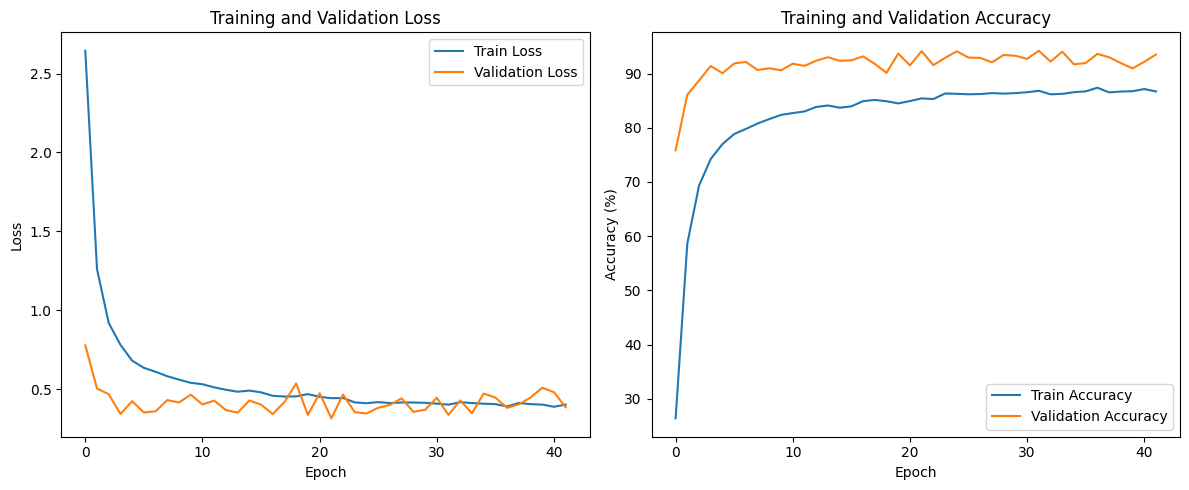

In [48]:
plt.figure(figsize=(12, 5))

# ---- loss ----
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# ---- accuracy ----
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [51]:
# 載入最佳模型
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model/best_model.pth"))
model.eval()

# 測試模型
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"📊 測試損失: {test_loss:.4f}, 測試準確率: {accuracy:.2f}%")


📊 測試損失: 0.3592, 測試準確率: 93.60%


In [52]:
# 測試模型
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in data3_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"📊 測試損失: {test_loss:.4f}, 測試準確率: {accuracy:.2f}%")

📊 測試損失: 211.3195, 測試準確率: 14.02%
